# Investigating the frequency and battery charge

We start by importing libaries that should have been installed when installing the package

The `dynamic_containment` module is part of this package

In [1]:
import pandas as pd
from datetime import timedelta, date
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from scipy import special
import openturns as ot
from scipy.optimize import least_squares
import warnings
from scipy.interpolate import interp1d
warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm

from dynamic_containment import utils

plt.rcParams['text.usetex'] = False

We have set up a function within `dynamic_containment` to calculate the charge associated with each change in frequency

Text(0, 0.5, 'Charge %')

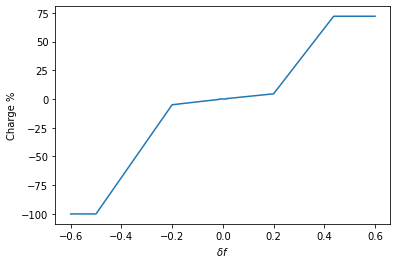

In [2]:
df = np.linspace(-0.6, 0.6, num=1000)

plt.plot(df, [100*utils.battery_power(dfi, 5) for dfi in df])
plt.xlabel("$\delta f$")
plt.ylabel("Charge %")

In [8]:
freq_table = pd.read_csv('data/task_data_1hz.tar.gz', compression='gzip', header=0, sep=', ', quotechar='"', error_bad_lines=False)

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xb0 in position 549: invalid start byte

In [5]:
freq_table = utils.read_and_clean(path=None)

ValueError: Invalid file path or buffer object type: <class 'NoneType'>

In [113]:
service_power = 2

In [114]:
max_missing = freq_table[freq_table.isnull().any(axis=1)].date.max()

In [115]:
start = max_missing.date() + timedelta(days=1)

In [116]:
end = freq_table.date.max().date()

In [117]:
cont_table = extract_time_block(start, end, freq_table)

In [118]:
cont_table.head()

,date,freq,delta_freq,battery_charge_percent_x,battery_charge_x,culm_charge_x,culm_charge_sq_x,var_charge_x,std_charge_x,filled_delta_freq,sim_delta_freq,battery_charge_percent_y,battery_charge_y,culm_charge_y,culm_charge_sq_y,var_charge_y,std_charge_y
1728000,2021-09-21 00:00:00,50.053,0.053,-0.025531,-0.255312,-2.525602,904.292780,11.685384,3.418389,0.053,-0.102125,-0.025531,-0.255312,-2.525602,904.292780,11.685384,3.418389
1728001,2021-09-21 00:00:01,50.048,0.048,-0.025699,-0.256993,-2.525602,904.291697,11.685373,3.418387,0.048,-0.102797,-0.025699,-0.256993,-2.525602,904.291697,11.685373,3.418387
1728002,2021-09-21 00:00:02,50.042,0.042,-0.025867,-0.258674,-2.525602,904.290622,11.685362,3.418386,0.042,-0.103470,-0.025867,-0.258674,-2.525602,904.290622,11.685362,3.418386
1728003,2021-09-21 00:00:03,50.035,0.035,-0.026036,-0.260355,-2.525602,904.289731,11.685353,3.418385,0.035,-0.104142,-0.026036,-0.260355,-2.525602,904.289731,11.685353,3.418385
1728004,2021-09-21 00:00:04,50.030,0.030,-0.026204,-0.262036,-2.525602,904.288732,11.685343,3.418383,0.030,-0.104814,-0.026204,-0.262036,-2.525602,904.288732,11.685343,3.418383


In [119]:
cont_table = add_charge_info(cont_table, service_power)

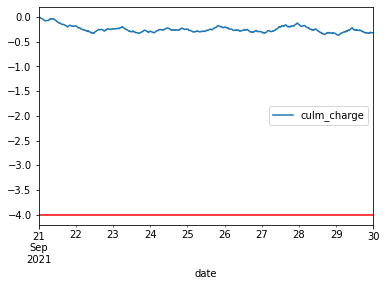

In [120]:
cont_table.plot('date', 'culm_charge')
plt.axhline(-4.0, color='red')

In [121]:
process = simulate_delta_f(cont_table)

In [122]:
# draw a sample
sample = process.getSample(1)

In [123]:
vals = [sample[0][i][0] for i in range(len(sample[0]))]

In [124]:
vals = np.array(vals) * freq_table.delta_freq.std() / np.std(vals)

In [125]:
freq_table.delta_freq.std()

0.059980953240247284

In [126]:
vals.std()

0.05998095324024727

In [36]:
df_sim = pd.DataFrame()
df_sim['date'] = range(len(vals))
df_sim['delta_freq'] = vals

In [37]:
df_sim = add_charge_info(df_sim, service_power)

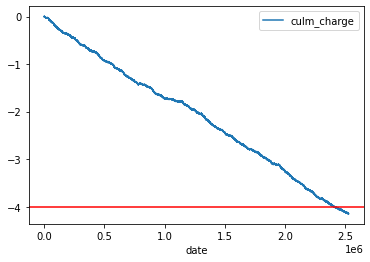

In [38]:
df_sim.plot('date', 'culm_charge')
plt.axhline(-4.0, color='red')

In [39]:
real_space_cov = temporal_covariance(freq_table, max_sep=3601, step=20)

  0%|          | 0/181 [00:00<?, ?it/s]

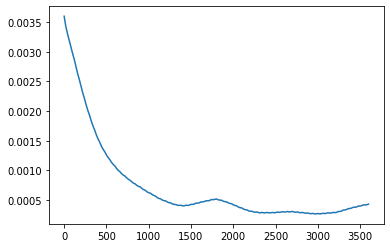

In [40]:
plt.plot(real_space_cov.keys(), real_space_cov.values())

In [41]:
len(freq_table)/3600

702.3055555555555

In [42]:
len(real_space_cov)

181

In [43]:
time_step = 10
num_samples = [100,703]

In [44]:
samples = simulate_grf_using_cov(real_space_cov, max_time=3600, time_step=time_step, num_samples=num_samples)

creating covariance
creating samples


In [45]:
samples = [s.flatten()[:len(freq_table.delta_freq)] for s in samples]

In [46]:
new_samples = interp_samples(samples, max_time=len(freq_table), step_samples=10)

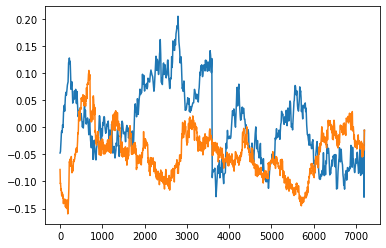

In [111]:
plt.plot(new_samples[2][:7200])
plt.plot(
    freq_table.delta_freq.iloc[:7200]
)

In [48]:
np.mean(new_samples[3])/(np.std(new_samples[3])/np.sqrt(len(new_samples[3])))

16.583601890469236

In [49]:
np.mean(freq_table.delta_freq)/(np.std(freq_table.delta_freq)/np.sqrt(len(freq_table.dropna())))

22.020277679009435

In [50]:
reals = {}

count = 0

for s in new_samples:
    
    if not count % 20:
        print(count)
    
    df = pd.DataFrame()
    df["date"] = range(len(s))
    df["delta_freq"] = s
    df = add_charge_info(df, service_power)
    
    reals[count] = df
    
    count+=1
    

0
20
40
60
80


In [62]:
np.mean(new_samples[3])/(np.std(new_samples[3])/np.sqrt(len(new_samples[3])))

16.583601890469236

In [63]:
np.mean(freq_table.delta_freq)/(np.std(freq_table.delta_freq)/np.sqrt(len(freq_table.dropna())))

22.01360932903019

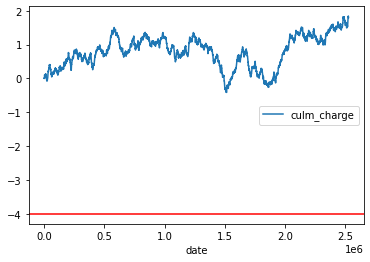

In [112]:
reals[2].plot('date', 'culm_charge')
plt.axhline(-4.0, color='red')

In [70]:
df_mean = reals[0]
df_mean['culm_charge'] = 0.0
df_mean['culm_charge_sq'] = 0.0

for s in reals:
    
    df_mean['culm_charge'] += reals[s]['culm_charge']
    df_mean['culm_charge_sq'] += reals[s]['culm_charge']**2.0
    


In [71]:
df_mean['culm_charge'] = df_mean['culm_charge'] / len(reals)

In [72]:
df_mean['var_charge'] = df_mean['culm_charge_sq'] / (len(reals) - 1) - df_mean['culm_charge'] * len(reals) / (len(reals) - 1)

In [73]:
df_mean['std_charge'] = np.sqrt(df_mean['var_charge'])

In [74]:
freq_table = fill_in_spectra(freq_table, reals[0])

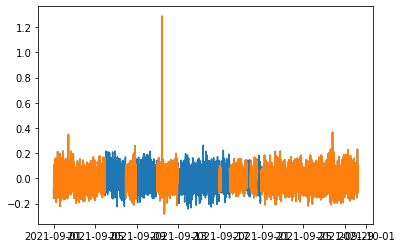

In [75]:
plt.plot(freq_table['date'], freq_table['filled_delta_freq'])
plt.plot(freq_table['date'], freq_table['delta_freq'])

In [78]:
gauss_noise = np.random.normal(0.0, freq_table['filled_delta_freq'].std(), size=len(freq_table))

In [79]:
df_white_noise = pd.DataFrame()
df_white_noise['date'] = range(len(freq_table))
df_white_noise['delta_freq'] = gauss_noise

In [80]:
df_white_noise = add_charge_info(df_white_noise, service_power)

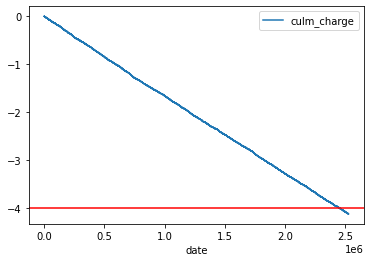

In [81]:
df_white_noise.plot('date', 'culm_charge')
plt.axhline(-4.0, color='red')

In [82]:
df_filled = add_charge_info(
    freq_table.drop('delta_freq', axis=1).rename({'filled_delta_freq': 'delta_freq'}, axis=1),
    service_power
)

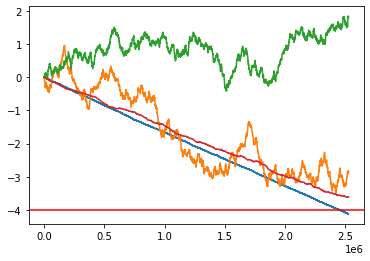

In [109]:
plt.plot(df_white_noise.date, df_white_noise.culm_charge)
plt.plot(df_white_noise.date, df_filled.culm_charge)
plt.plot(df_white_noise.date, reals[2].culm_charge)
plt.plot(df_white_noise.date, df_mean.culm_charge)
plt.axhline(-4.0, color='red')

In [86]:
c = calc_gaussian_slope(freq_table.delta_freq.std(), service_power)

In [87]:
theory_charge = c * np.arange(len(df_white_noise))

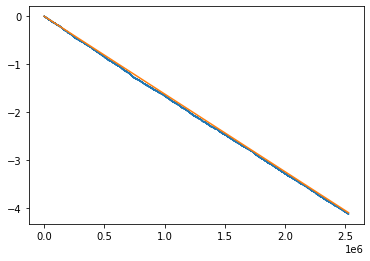

In [88]:
plt.plot(df_white_noise.date, df_white_noise.culm_charge)
plt.plot(df_white_noise.date, theory_charge)

In [89]:
c_hist = calc_data_slope(df_filled, service_power, bins=34)

In [90]:
theory_charge_hist = c_hist * np.arange(len(df_white_noise))

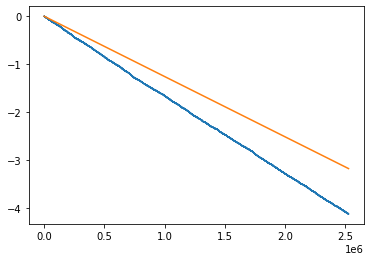

In [91]:
plt.plot(df_white_noise.date, df_white_noise.culm_charge)
plt.plot(df_white_noise.date, theory_charge_hist)

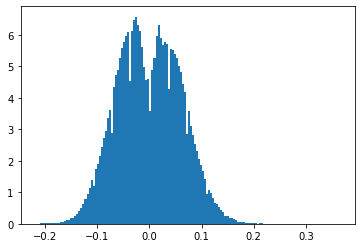

In [92]:
hist = plt.hist(cont_table.delta_freq, bins=150, density=True)

In [93]:
bin_cents = 0.5*(hist[1][1:] + hist[1][:-1])

In [94]:
f = least_squares(hist_fit, x0 = [0.04, 0.04], args=(bin_cents, hist[0]))

In [95]:
gauss1 = normal_dist(bin_cents, f.x[1], mu=-f.x[0])
gauss2 = normal_dist(bin_cents, f.x[1], mu=f.x[0])

In [96]:
gauss = np.where(bin_cents<0, gauss1, gauss2)
gauss = gauss / np.trapz(gauss, bin_cents)

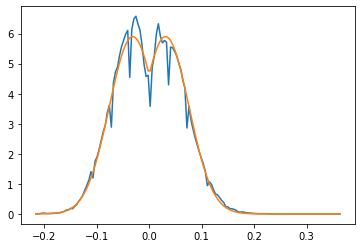

In [97]:
plt.plot(bin_cents, hist[0])
plt.plot(bin_cents, gauss)

In [98]:
samples = generate_sample_df(gauss, bin_cents, num_samps=len(freq_table))

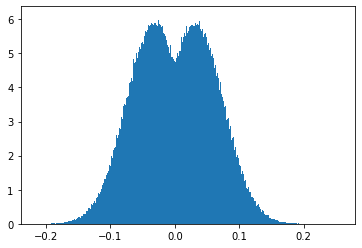

In [99]:
hist_samp = plt.hist(samples, density=True, bins=1000)


In [100]:
samples.mean()

3.1764371075468695e-05

In [101]:
np.trapz(gauss * bin_cents, bin_cents)

2.5526445847651874e-06

In [102]:
samples.std()

0.05950496995446176

In [103]:
sample_df = pd.DataFrame()
sample_df["date"] = range(len(samples))
sample_df["delta_freq"] = samples

In [104]:
sample_df = add_charge_info(sample_df, service_power)

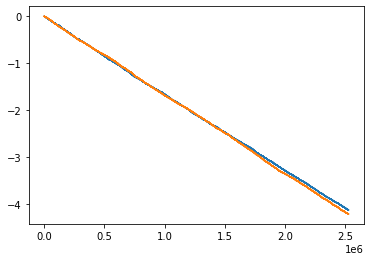

In [105]:
plt.plot(df_white_noise.date, df_white_noise.culm_charge)
plt.plot(sample_df.date, sample_df.culm_charge)

In [106]:
fitted_c = calc_fitted_slope(gauss, bin_cents, service_power)

In [107]:
theory_charge_hist = fitted_c * np.arange(len(df_white_noise))

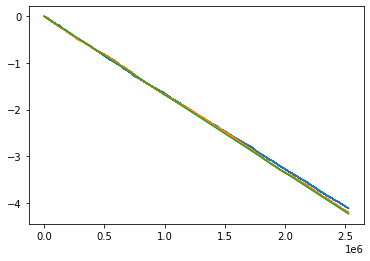

In [108]:
plt.plot(df_white_noise.date, df_white_noise.culm_charge)
plt.plot(sample_df.date, sample_df.culm_charge)
plt.plot(df_white_noise.date, theory_charge_hist)

In [ ]:
E0 = 4
(-4.0 - E0)/fitted_c

In [ ]:
(-4.0 - E0)/fitted_c/(3600.0 * 24.0)